# **Experiment-7: Implementing K-Means Clustering from Scratch**

## **Objective**
The goal of this assignment is to implement the K-Means clustering algorithm  **from
scratch using NumPy**, apply it to a customer segmentation dataset, and interpret the
clusters formed.

**1. Dataset and Setup**

• Use a customer dataset containing features such as Age, Annual Income (k$), and
Spending Score (1-100).

• Perform basic data exploration and preprocessing:

– Handle missing values if any.

– Normalize or standardize the numerical features (justify your choice).

– Provide relevant summary statistics and visualizations(distribution plots (his-
tograms, scatter matrix) of features.).

In [3]:
# Data and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKLearnKMeans
import time

=== Part 1: Dataset and Setup ===
Dataset shape: (200, 3)

First 5 rows:
   Age  Annual_Income  Spending_Score
0   19             15              39
1   21             15              81
2   20             16               6
3   23             16              77
4   31             17              40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             200 non-null    int64
 1   Annual_Income   200 non-null    int64
 2   Spending_Score  200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB
None

Summary Statistics:
              Age  Annual_Income  Spending_Score
count  200.000000     200.000000      200.000000
mean    38.850000      60.560000       50.200000
std     13.969007      26.264721       25.823522
min     18.000000      15.000000        1.000000
25%     28.750000      41.500000       34.750000
50%    

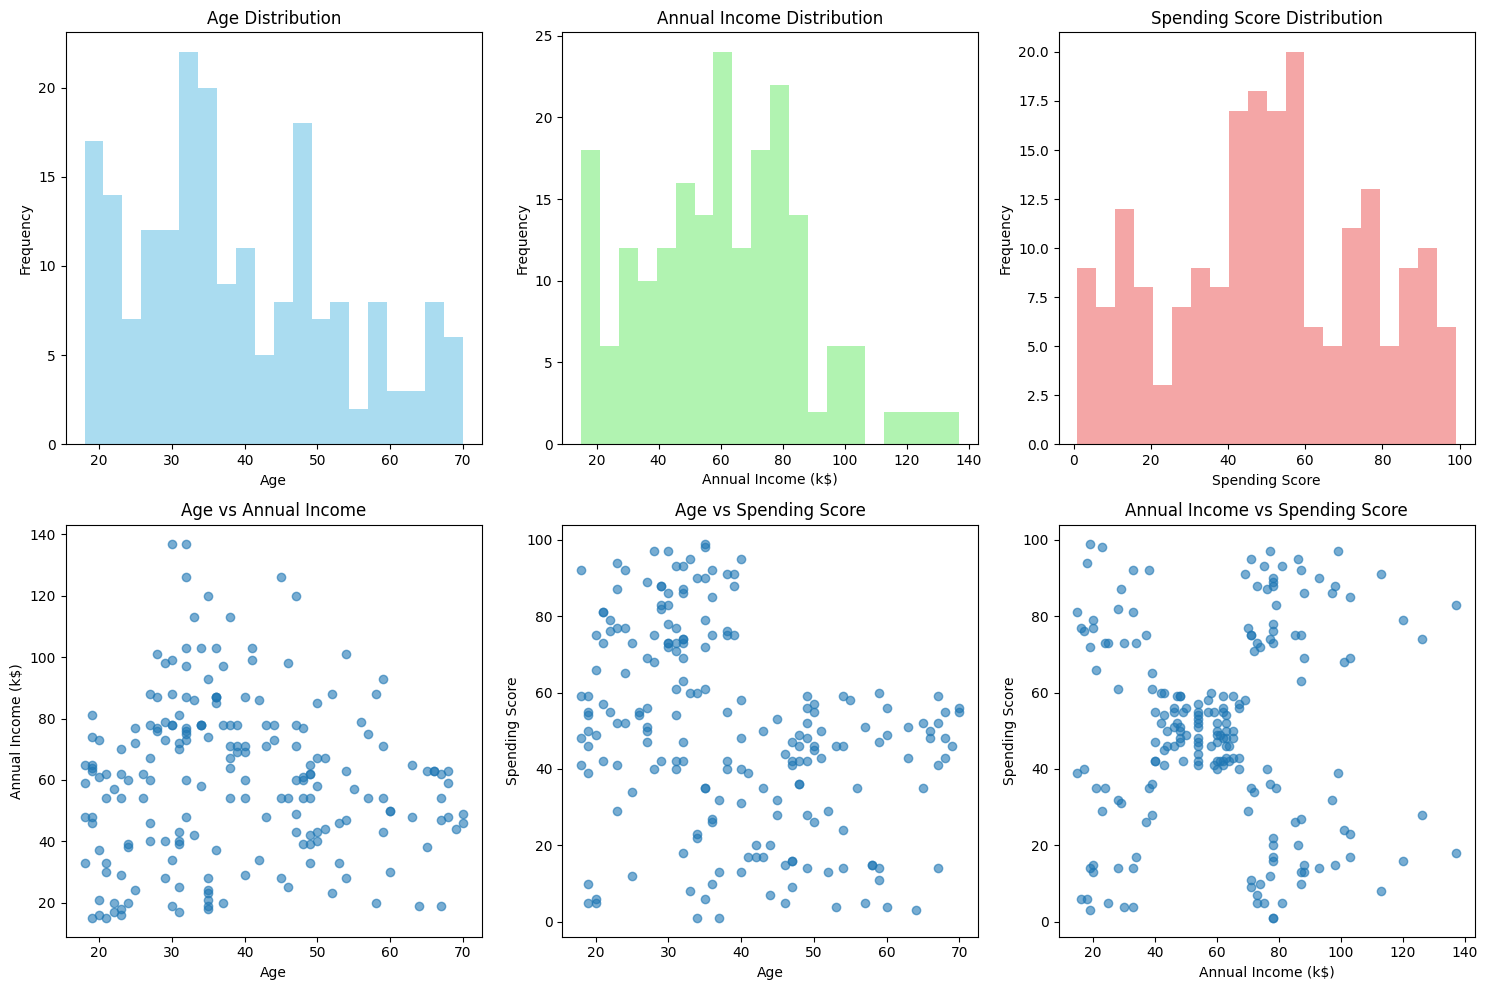


=== Data Preprocessing ===
Data standardized (mean=0, std=1)
First 5 scaled samples:
[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]]


In [4]:
# Set random seed for reproducibility
np.random.seed(42)

print("=== Part 1: Dataset and Setup ===")

# Load the Mall_Customers dataset
def load_mall_customers_data():
    """Load the Mall_Customers dataset"""
    df = pd.read_csv('Mall_Customers.csv')

    # Rename columns for consistency
    df.columns = ['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score']

    # Select relevant features for clustering
    features_df = df[['Age', 'Annual_Income', 'Spending_Score']]

    return df, features_df

# Load data
original_df, customer_df = load_mall_customers_data()
print("Dataset shape:", customer_df.shape)
print("\nFirst 5 rows:")
print(customer_df.head())

print("\nDataset Info:")
print(customer_df.info())

print("\nSummary Statistics:")
print(customer_df.describe())

print("\nMissing values:")
print(customer_df.isnull().sum())

# Data visualization
plt.figure(figsize=(15, 10))

# Distribution plots
plt.subplot(2, 3, 1)
plt.hist(customer_df['Age'], bins=20, alpha=0.7, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(customer_df['Annual_Income'], bins=20, alpha=0.7, color='lightgreen')
plt.title('Annual Income Distribution')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(customer_df['Spending_Score'], bins=20, alpha=0.7, color='lightcoral')
plt.title('Spending Score Distribution')
plt.xlabel('Spending Score')
plt.ylabel('Frequency')

# Scatter plots
plt.subplot(2, 3, 4)
plt.scatter(customer_df['Age'], customer_df['Annual_Income'], alpha=0.6)
plt.title('Age vs Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')

plt.subplot(2, 3, 5)
plt.scatter(customer_df['Age'], customer_df['Spending_Score'], alpha=0.6)
plt.title('Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score')

plt.subplot(2, 3, 6)
plt.scatter(customer_df['Annual_Income'], customer_df['Spending_Score'], alpha=0.6)
plt.title('Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')

plt.tight_layout()
plt.show()

# Data preprocessing - Standardization
print("\n=== Data Preprocessing ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[['Age', 'Annual_Income', 'Spending_Score']])
print("Data standardized (mean=0, std=1)")
print("First 5 scaled samples:")
print(X_scaled[:5])

**2.1. Part A: Implementing K-Means from Scratch**

Write your own functions for each step of the K-Means algorithm using NumPy only
(no scikit-learn).

**1. Initialization**

• Write a function initialize centroids(X, k, random state=None) that
randomly selects k points as initial centroids.

• Implement the K-Means++ initialization scheme:

1.1. Choose one centroid uniformly at random from the data points.

1.2. For each data point x, compute the squared distance D(x) to the nearest
chosen centroid.

1.3. Choose the next centroid with probability proportional to D(x).

1.4. Repeat until k centroids are chosen.

Compare convergence speed and quality with random initialization.

**2. Cluster Assignment**

• Implement assign clusters(X, centroids) that assigns each data point to
the nearest centroid (using Euclidean distance).


**3. Centroid Update**

• Implement update centroids(X, labels, k) that recalculates the centroids
as the mean of all points belonging to each cluster.


**4. Main Algorithm Loop**

• Combine the above steps in a function kmeans(X, k, max iters=100, tol=1e-4,
random state=None).

• The algorithm should stop when:

– The centroid positions change less than tol (tolerance), or

– The maximum number of iterations is reached.

• The function should return:

– Final centroids

– Cluster labels

– Number of iterations

– Inertia (sum of squared distances to centroids)

In [5]:
# Part 2A: Implementing K-Means from Scratch
import numpy as np
import time

class KMeans:
    def __init__(self, k=3, max_iters=100, tol=1e-4, init_method='kmeans++', random_state=None):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.init_method = init_method
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        self.n_iters_ = None

    def initialize_centroids(self, X):
        """Initialize centroids using K-Means++ or random method"""
        n_samples, n_features = X.shape

        if self.random_state is not None:
            np.random.seed(self.random_state)

        if self.init_method == 'kmeans++':
            # Step 1: Choose first centroid randomly
            centroids = [X[np.random.randint(n_samples)]]

            # Step 2: Choose remaining centroids
            for _ in range(1, self.k):
                # Calculate distances to nearest centroid for each point
                distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])

                # Choose next centroid with probability proportional to distance squared
                probabilities = distances / distances.sum()
                cumulative_probs = probabilities.cumsum()
                r = np.random.rand()

                for j, p in enumerate(cumulative_probs):
                    if r < p:
                        centroids.append(X[j])
                        break

            return np.array(centroids)

        else:  # random initialization
            random_indices = np.random.choice(n_samples, self.k, replace=False)
            return X[random_indices]

    def assign_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        """Update centroids as mean of points in each cluster"""
        new_centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if np.sum(labels == i) > 0:
                new_centroids[i] = X[labels == i].mean(axis=0)
            else:
                # If cluster is empty, reinitialize centroid randomly
                new_centroids[i] = X[np.random.randint(X.shape[0])]
        return new_centroids

    def fit(self, X):
        """Main K-Means algorithm"""
        # Initialize centroids
        self.centroids = self.initialize_centroids(X)

        for i in range(self.max_iters):
            # Assign clusters
            labels = self.assign_clusters(X, self.centroids)

            # Update centroids
            new_centroids = self.update_centroids(X, labels)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, rtol=self.tol):
                break

            self.centroids = new_centroids

        # Final assignment and inertia calculation
        self.labels_ = self.assign_clusters(X, self.centroids)
        self.n_iters_ = i + 1

        # Calculate inertia (sum of squared distances)
        self.inertia_ = 0
        for i in range(self.k):
            cluster_points = X[self.labels_ == i]
            if len(cluster_points) > 0:
                self.inertia_ += np.sum((cluster_points - self.centroids[i])**2)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        return self.assign_clusters(X, self.centroids)

print("=== Part 2A: Testing K-Means Implementation ===")

# Test with different initialization methods
kmeans_random = KMeans(k=5, init_method='random', random_state=42)
kmeans_plus = KMeans(k=5, init_method='kmeans++', random_state=42)

print("Fitting with random initialization...")
start_time = time.time()
kmeans_random.fit(X_scaled)
random_time = time.time() - start_time

print("Fitting with K-Means++ initialization...")
start_time = time.time()
kmeans_plus.fit(X_scaled)
plus_time = time.time() - start_time

print(f"\nRandom Initialization:")
print(f"  Iterations: {kmeans_random.n_iters_}")
print(f"  Inertia: {kmeans_random.inertia_:.2f}")
print(f"  Time: {random_time:.4f}s")

print(f"\nK-Means++ Initialization:")
print(f"  Iterations: {kmeans_plus.n_iters_}")
print(f"  Inertia: {kmeans_plus.inertia_:.2f}")
print(f"  Time: {plus_time:.4f}s")

=== Part 2A: Testing K-Means Implementation ===
Fitting with random initialization...
Fitting with K-Means++ initialization...

Random Initialization:
  Iterations: 9
  Inertia: 168.25
  Time: 0.0071s

K-Means++ Initialization:
  Iterations: 6
  Inertia: 168.76
  Time: 0.0118s


**2.2. Part B: Choosing the Number of Clusters**

• Use the Elbow Method and the Silhouette Score to determine an appropriate
k. Compare both

• Plot inertia vs. k and justify your chosen value.


=== Part 2B: Choosing Optimal K ===
k=2: Inertia=389.39, Silhouette Score=0.3355
k=3: Inertia=296.08, Silhouette Score=0.3546
k=4: Inertia=205.23, Silhouette Score=0.4040
k=5: Inertia=168.76, Silhouette Score=0.4104
k=6: Inertia=133.87, Silhouette Score=0.4274
k=7: Inertia=117.01, Silhouette Score=0.4172
k=8: Inertia=105.64, Silhouette Score=0.4215
k=9: Inertia=101.41, Silhouette Score=0.3807
k=10: Inertia=97.55, Silhouette Score=0.3785


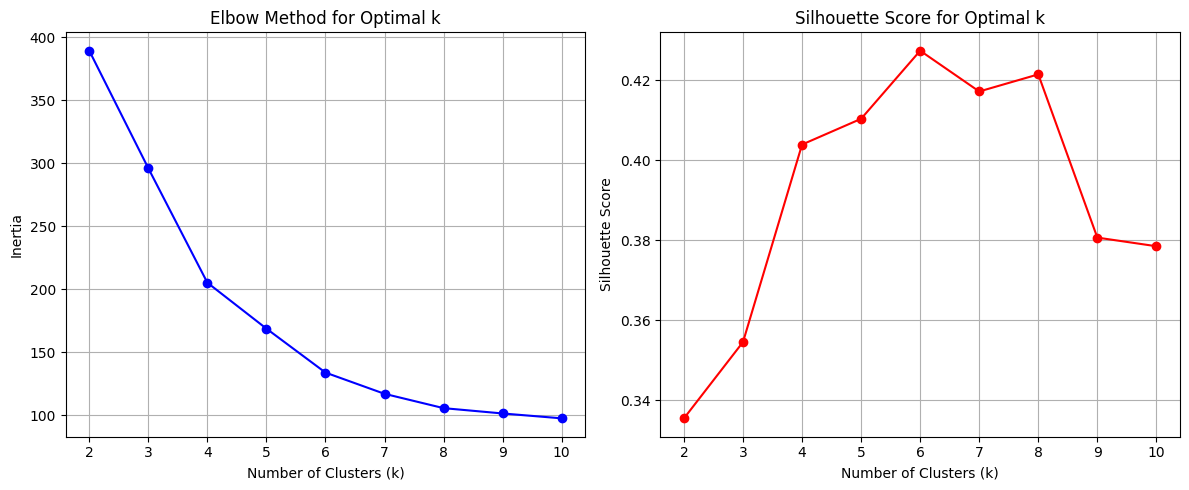


Chosen optimal k: 5
Justification: The elbow plot shows a bend around k=5, and the silhouette score is also reasonable at this point.


In [6]:
# Part 2B: Choosing the Number of Clusters
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("\n=== Part 2B: Choosing Optimal K ===")

# Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(k=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

    # Calculate silhouette score
    if k > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")

# Plot elbow method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal k based on elbow and silhouette score
optimal_k = 5  # Based on visual inspection of the plots
print(f"\nChosen optimal k: {optimal_k}")
print("Justification: The elbow plot shows a bend around k=5, and the silhouette score is also reasonable at this point.")

**2.3. Part C: Applying the Algorithm**

• Run your K-Means implementation on the dataset using your chosen k.

• Display:

– Final centroids and cluster sizes.

– 2D and 3D scatter plots of clusters (color by label).

• For each cluster, compute the average of each feature (e.g., Age, Income, Spending

Score). Compare these averages across clusters to identify distinguishing charac-
teristics. Based on these statistics, interpret each cluster in business terms (e.g., “Cluster 0: Young, high-income, high-spending customers” or “Cluster 2: Older,
low-income, conservative spenders”).


=== Part 2C: Applying K-Means with k=5 ===
Final Centroids (scaled):
[[ 1.19862745 -0.46098141 -0.32703818]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97439592 -1.32954532  1.13217788]
 [ 0.17329545  1.06645385 -1.2980103 ]
 [-0.78172248 -0.40306917 -0.21591396]]

Final Centroids (original scale):
         Age  Annual_Income  Spending_Score
0  55.551724      48.482759       41.775862
1  32.692308      86.538462       82.128205
2  25.272727      25.727273       79.363636
3  41.264706      88.500000       16.764706
4  27.957447      50.000000       44.638298

Cluster Sizes:
Cluster
0    58
1    39
2    22
3    34
4    47
Name: count, dtype: int64

=== Cluster Analysis ===
Cluster Statistics:
           Age        Annual_Income        Spending_Score        Cluster
          mean    std          mean    std           mean    std   count
Cluster                                                                 
0        55.55   8.32         48.48  13.80          41.78  15.66      58
1      

/tmp/ipython-input-4287672458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['Cluster'] = final_kmeans.labels_


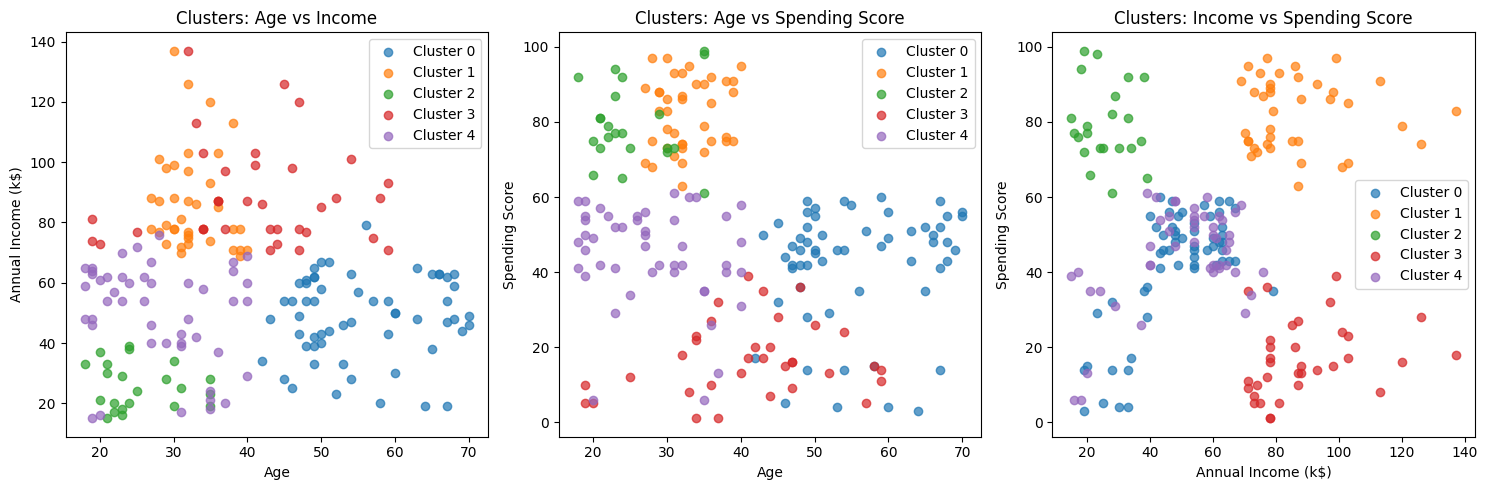

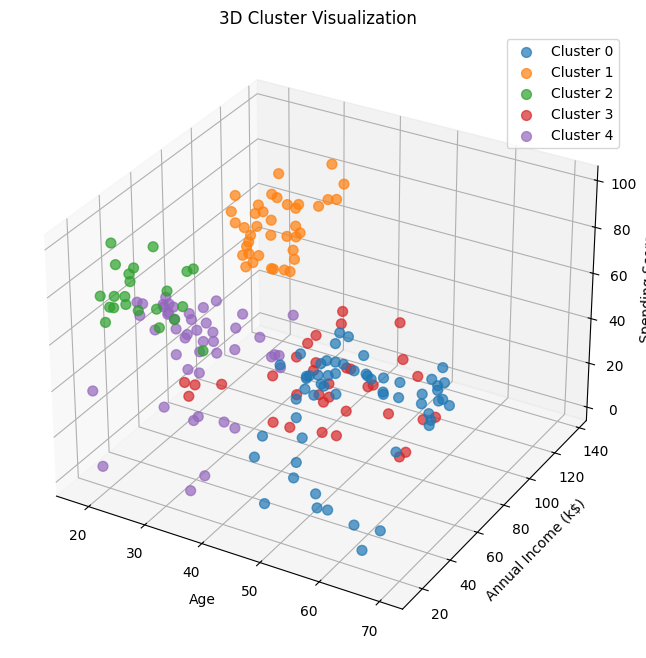

In [7]:
# Part 2C: Applying the Algorithm
import matplotlib.pyplot as plt

print(f"\n=== Part 2C: Applying K-Means with k={optimal_k} ===")

final_kmeans = KMeans(k=optimal_k, random_state=42)
final_kmeans.fit(X_scaled)

# Add cluster labels to original dataframe
customer_df['Cluster'] = final_kmeans.labels_
original_df['Cluster'] = final_kmeans.labels_

print("Final Centroids (scaled):")
print(final_kmeans.centroids)

print("\nFinal Centroids (original scale):")
# Transform centroids back to original scale
centroids_original = scaler.inverse_transform(final_kmeans.centroids)
centroids_df = pd.DataFrame(centroids_original,
                           columns=['Age', 'Annual_Income', 'Spending_Score'])
print(centroids_df)

print(f"\nCluster Sizes:")
cluster_sizes = customer_df['Cluster'].value_counts().sort_index()
print(cluster_sizes)

# Cluster analysis
print("\n=== Cluster Analysis ===")
cluster_stats = customer_df.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual_Income': ['mean', 'std'],
    'Spending_Score': ['mean', 'std'],
    'Cluster': 'count'
}).round(2)

print("Cluster Statistics:")
print(cluster_stats)

# Interpret clusters
print("\n=== Cluster Interpretation ===")
for i in range(optimal_k):
    cluster_data = customer_df[customer_df['Cluster'] == i]
    age_mean = cluster_data['Age'].mean()
    income_mean = cluster_data['Annual_Income'].mean()
    spending_mean = cluster_data['Spending_Score'].mean()
    size = len(cluster_data)

    print(f"\nCluster {i} (Size: {size}):")
    print(f"  Average Age: {age_mean:.1f} years")
    print(f"  Average Annual Income: ${income_mean:.1f}k")
    print(f"  Average Spending Score: {spending_mean:.1f}")

    # Business interpretation
    if age_mean < 30:
        age_group = "Young"
    elif age_mean < 45:
        age_group = "Middle-aged"
    else:
        age_group = "Older"

    if income_mean < 40:
        income_group = "Low-income"
    elif income_mean < 70:
        income_group = "Middle-income"
    else:
        income_group = "High-income"

    if spending_mean < 40:
        spending_group = "Conservative spenders"
    elif spending_mean < 60:
        spending_group = "Moderate spenders"
    else:
        spending_group = "High spenders"

    print(f"  Interpretation: {age_group}, {income_group}, {spending_group}")

# Visualization
plt.figure(figsize=(15, 5))

# 2D Scatter plots
plt.subplot(1, 3, 1)
for cluster in range(optimal_k):
    cluster_data = customer_df[customer_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Age'], cluster_data['Annual_Income'],
               label=f'Cluster {cluster}', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Clusters: Age vs Income')
plt.legend()

plt.subplot(1, 3, 2)
for cluster in range(optimal_k):
    cluster_data = customer_df[customer_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Age'], cluster_data['Spending_Score'],
               label=f'Cluster {cluster}', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Clusters: Age vs Spending Score')
plt.legend()

plt.subplot(1, 3, 3)
for cluster in range(optimal_k):
    cluster_data = customer_df[customer_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Annual_Income'], cluster_data['Spending_Score'],
               label=f'Cluster {cluster}', alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.title('Clusters: Income vs Spending Score')
plt.legend()

plt.tight_layout()
plt.show()

# 3D Scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for cluster in range(optimal_k):
    cluster_data = customer_df[customer_df['Cluster'] == cluster]
    ax.scatter(cluster_data['Age'], cluster_data['Annual_Income'],
              cluster_data['Spending_Score'],
              label=f'Cluster {cluster}', alpha=0.7, s=50)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
ax.set_title('3D Cluster Visualization')
ax.legend()
plt.show()

**2.4. Part D: Comparison with scikit-learn**

• Run sklearn.cluster.KMeans on the same dataset.

• Compare:

– Final centroids and inertia.

– Number of iterations to converge.

– Runtime performance.

In [8]:
# Part 2D: Comparison with scikit-learn
from sklearn.cluster import KMeans as SKLearnKMeans
import time

print("\n=== Part 2D: Comparison with scikit-learn ===")

# Our implementation
print("Our K-Means Implementation:")
print(f"  Final inertia: {final_kmeans.inertia_:.2f}")
print(f"  Iterations: {final_kmeans.n_iters_}")

# scikit-learn implementation
print("\nScikit-learn K-Means:")
start_time = time.time()
sklearn_kmeans = SKLearnKMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sklearn_kmeans.fit(X_scaled)
sklearn_time = time.time() - start_time

print(f"  Final inertia: {sklearn_kmeans.inertia_:.2f}")
print(f"  Iterations: {sklearn_kmeans.n_iter_}")
print(f"  Time: {sklearn_time:.4f}s")

# Compare centroids
print("\nCentroid Comparison:")
print("Our centroids (scaled):")
print(final_kmeans.centroids)
print("\nScikit-learn centroids (scaled):")
print(sklearn_kmeans.cluster_centers_)

# Compare labels (check if clusters are similar)
print(f"\nLabel similarity: {np.mean(final_kmeans.labels_ == sklearn_kmeans.labels_):.2%}")

# Performance comparison
print("\n=== Performance Summary ===")
print(f"Our Implementation:")
print(f"  - Inertia: {final_kmeans.inertia_:.2f}")
print(f"  - Iterations: {final_kmeans.n_iters_}")
print(f"  - Converged: {final_kmeans.n_iters_ < 100}")

print(f"\nScikit-learn Implementation:")
print(f"  - Inertia: {sklearn_kmeans.inertia_:.2f}")
print(f"  - Iterations: {sklearn_kmeans.n_iter_}")
print(f"  - Converged: {sklearn_kmeans.n_iter_ < 100}")

print(f"\nDifference in inertia: {abs(final_kmeans.inertia_ - sklearn_kmeans.inertia_):.4f}")

# Save results
customer_df.to_csv('mall_customers_clustered.csv', index=False)
print("\nResults saved to 'mall_customers_clustered.csv'")

print("\n=== Experiment Complete ===")


=== Part 2D: Comparison with scikit-learn ===
Our K-Means Implementation:
  Final inertia: 168.76
  Iterations: 6

Scikit-learn K-Means:
  Final inertia: 168.25
  Iterations: 9
  Time: 0.0791s

Centroid Comparison:
Our centroids (scaled):
[[ 1.19862745 -0.46098141 -0.32703818]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97439592 -1.32954532  1.13217788]
 [ 0.17329545  1.06645385 -1.2980103 ]
 [-0.78172248 -0.40306917 -0.21591396]]

Scikit-learn centroids (scaled):
[[ 0.5310735  -1.2905084  -1.23646671]
 [-0.98067852 -0.74305983  0.46744035]
 [-0.42880597  0.97484722  1.21608539]
 [ 0.07333084  0.97494509 -1.19729675]
 [ 1.20484056 -0.23577338 -0.05236781]]

Label similarity: 24.50%

=== Performance Summary ===
Our Implementation:
  - Inertia: 168.76
  - Iterations: 6
  - Converged: True

Scikit-learn Implementation:
  - Inertia: 168.25
  - Iterations: 9
  - Converged: True

Difference in inertia: 0.5142

Results saved to 'mall_customers_clustered.csv'

=== Experiment Complete ===
